# CLIP Model Fine-tuning for Smile Detection

In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-4w2vmpur
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-4w2vmpur
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install transformers pillow torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from transformers import CLIPProcessor, CLIPModel
import torch
import fsspec
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import sys
import importlib.util
from ipywidgets import Output
from IPython.display import display
import os
import json
from PIL import Image
from io import BytesIO
import requests
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import random
import shutil
import glob
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
import torch.nn as nn
import copy
import time

DOWNLOAD_DATA = False

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device).eval()

fs = fsspec.filesystem("hf")
with fs.open("datasets/OpenFace-CQUPT/FaceCaption-15M/FaceCaption-v2.parquet") as f:
    pq_file = pq.ParquetFile(f)
    table = pq_file.read_row_group(0, columns=['caption','url'])
    df = table.to_pandas()

df = df[df['caption'].notnull() & df['url'].notnull()]
df = df[df['caption'].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x)>0)]
df['caption_text'] = df['caption'].apply(lambda x: str(x[0]).strip().lower())
df['url'] = df['url'].apply(lambda x: x.split(',')[0].strip())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

## Data filtering

In [6]:
DOWNLOAD_COUNT = {
    "smiling": 1000,
    "not-smiling": 1000
}

df_smile = df[df['caption_text'].str.contains('smil', na=False)]

df_no_smile_basic = df[~df['caption_text'].str.contains('smil|grin', na=False)]
non_smile_expressions = ['neutral ', 'sad ', 'angry ', 'mad ']
pattern = '|'.join(non_smile_expressions)
df_with_expressions = df_no_smile_basic[df_no_smile_basic['caption_text'].str.contains(pattern, case=False, na=False)]
df_not_smile = (
    df_with_expressions
    if len(df_with_expressions) >= DOWNLOAD_COUNT['not-smiling']
    else df_no_smile_basic
)

## Downloading data

In [7]:
dirs = {
    'smiling': {
        'images': '/content/drive/MyDrive/gmm-projektinis/images/smiling',
        'metadata': '/content/drive/MyDrive/gmm-projektinis/metadata/smiling'
    },
    'not-smiling': {
        'images': '/content/drive/MyDrive/gmm-projektinis/images/not-smiling',
        'metadata': '/content/drive/MyDrive/gmm-projektinis/metadata/not-smiling'
    }
}
for cat, paths in dirs.items():
    os.makedirs(paths['images'], exist_ok=True)
    os.makedirs(paths['metadata'], exist_ok=True)

download_output = Output()

if DOWNLOAD_DATA:
    download_output.clear_output()
    with download_output:
        for category, df_source in [('smiling', df_smile), ('not-smiling', df_not_smile)]:
            saved = 0
            print(f"Starting download for '{category}' (target: {DOWNLOAD_COUNT[category]})")
            iterator = (
                df_source.itertuples(index=False)
                if category == 'smiling' else
                df_source.sample(n=min(len(df_source), DOWNLOAD_COUNT[category] * 5)).itertuples(index=False)
            )
            for idx, row in enumerate(iterator, start=1):
                if saved >= DOWNLOAD_COUNT[category]:
                    break
                try:
                    resp = requests.get(row.url, timeout=5)
                    resp.raise_for_status()
                    img = Image.open(BytesIO(resp.content)).convert('RGB')
                except Exception:
                    continue

                img_fname = f"{category.replace('-', '_')}_{idx:05d}.jpg"
                img.save(os.path.join(dirs[category]['images'], img_fname))

                raw_caption = (
                    row.caption if isinstance(row.caption, list)
                    else (row.caption.tolist() if isinstance(row.caption, np.ndarray) else [row.caption])
                )
                metadata = {
                    'url': row.url,
                    'caption_text': row.caption_text,
                    'raw_caption': raw_caption
                }
                meta_fname = f"{category.replace('-', '_')}_{idx:05d}.json"
                with open(os.path.join(dirs[category]['metadata'], meta_fname), 'w', encoding='utf-8') as f:
                    json.dump(metadata, f, ensure_ascii=False, indent=2)

                saved += 1
                if category == 'not-smiling' and saved % 10 == 0:
                    print(f"Downloaded {saved}/{DOWNLOAD_COUNT[category]} non-smiling images")

            if saved > 0:
                sample_img = os.path.join(dirs[category]['images'], img_fname)
                display(Image.open(sample_img))

In [8]:
clip_spec = importlib.util.find_spec("clip")
if clip_spec:
    print(f"CLIP found at: {clip_spec.origin}")
else:
    print("CLIP module not found in sys.path")

try:
    import clip
except ImportError as e:
    print(f"Error importing CLIP: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

CLIP found at: /usr/local/lib/python3.11/dist-packages/clip/__init__.py


## Alternative CLIP Implementation

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def encode_image(model, processor, images, device):
    with torch.no_grad():
        inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
        outputs = model.get_image_features(**inputs)
        return outputs

def encode_text(model, processor, texts, device):
    with torch.no_grad():
        inputs = processor(text=texts, return_tensors="pt", padding=True).to(device)
        outputs = model.get_text_features(**inputs)
        return outputs

Using device: cuda


## Creating Train-Test Split

In [10]:
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.1

SOURCE_DIR = "/content/drive/MyDrive/gmm-projektinis"
TARGET_DIR = "/content/drive/MyDrive/gmm-projektinis/data"

if DOWNLOAD_DATA:
    for category in ['smiling', 'not-smiling']:
        for split in ['train', 'validation', 'test']:
            os.makedirs(f'{TARGET_DIR}/{split}/images/{category}', exist_ok=True)
            os.makedirs(f'{TARGET_DIR}/{split}/metadata/{category}', exist_ok=True)

    for category in ['smiling', 'not-smiling']:
        img_files = glob.glob(f'{SOURCE_DIR}/images/{category}/*.jpg')

        meta_files = [f.replace('/images/', '/metadata/').replace('.jpg', '.json') for f in img_files]

        train_val_img, test_img, train_val_meta, test_meta = train_test_split(
            img_files, meta_files, test_size=TEST_SPLIT, random_state=42
        )

        val_size = VALIDATION_SPLIT / (1 - TEST_SPLIT)
        train_img, val_img, train_meta, val_meta = train_test_split(
            train_val_img, train_val_meta, test_size=val_size, random_state=42
        )

        for split_name, img_list, meta_list in [
            ('train', train_img, train_meta),
            ('validation', val_img, val_meta),
            ('test', test_img, test_meta)
        ]:
            for img_file, meta_file in zip(img_list, meta_list):
                img_filename = os.path.basename(img_file)
                meta_filename = os.path.basename(meta_file)

                img_dest = f'{TARGET_DIR}/{split_name}/images/{category}/{img_filename}'
                meta_dest = f'{TARGET_DIR}/{split_name}/metadata/{category}/{meta_filename}'

                shutil.copy(img_file, img_dest)
                shutil.copy(meta_file, meta_dest)

            print(f"Category '{category}' - {split_name}: {len(img_list)} images")

## Loading Pre-trained CLIP Model

In [14]:
class SmileDataset(Dataset):
    def __init__(self, root_dir, split="train", processor=None):
        self.root_dir = root_dir
        self.split = split
        self.processor = processor

        self.samples = []

        for category in ["smiling", "not-smiling"]:
            img_dir = os.path.join(root_dir, split, "images", category)
            meta_dir = os.path.join(root_dir, split, "metadata", category)

            img_files = glob.glob(os.path.join(img_dir, "*.jpg"))

            for img_file in img_files:
                img_name = os.path.basename(img_file)
                meta_file = os.path.join(meta_dir, img_name.replace(".jpg", ".json"))

                if os.path.exists(meta_file):
                    with open(meta_file, 'r') as f:
                        metadata = json.load(f)

                    self.samples.append({
                        "image_path": img_file,
                        "caption": metadata["caption_text"] if "caption_text" in metadata else metadata.get("raw_caption", [""])[0],
                        "label": 1 if category == "smiling" else 0
                    })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        image = Image.open(sample["image_path"]).convert("RGB")

        return {
            "image": image,
            "caption": sample["caption"],
            "label": sample["label"],
            "image_path": sample["image_path"]
        }

DATA_ROOT = "/content/drive/MyDrive/gmm-projektinis/data"

train_dataset = SmileDataset(root_dir=DATA_ROOT, split="train", processor=processor)
val_dataset = SmileDataset(root_dir=DATA_ROOT, split="validation", processor=processor)
test_dataset = SmileDataset(root_dir=DATA_ROOT, split="test", processor=processor)

def collate_fn(batch):
    images = [item["image"] for item in batch]
    captions = [item["caption"] for item in batch]
    labels = torch.tensor([item["label"] for item in batch])
    image_paths = [item["image_path"] for item in batch]

    return {
        "image": images,
        "caption": captions,
        "label": labels,
        "image_path": image_paths
    }

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

Training samples: 1600
Validation samples: 200
Testing samples: 200


## Fine-tuning CLIP Model

In [17]:
for name, param in model.named_parameters():
    if 'projection' in name and 'weight' in name:
        PROJECTION_DIM = param.shape[0]
        break
else:
    PROJECTION_DIM = 512

# Compute class weights
counts = torch.tensor([
    sum((batch["label"] == i).sum().item() for batch in train_loader)
    for i in (0, 1)
], dtype=torch.float, device=device)

In [19]:
num_epochs    = 50
learning_rate = 5e-5
max_grad_norm = 1.0
weight_decay  = 0.01
patience      = 6
min_delta     = 0.001

pretrained_state = {
    k: v.clone().detach()
    for k, v in model.state_dict().items()
}

class ClassificationHead(nn.Sequential):
    def __init__(
        self,
        input_dim: int = PROJECTION_DIM,
        hidden_dims: list[int] = (512, 256, 128),
        dropout_rate: float = 0.3,
    ):
        layers = []
        for dim in hidden_dims:
            layers += [
                nn.Linear(input_dim, dim),
                nn.BatchNorm1d(dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
            ]
            input_dim = dim
        layers.append(nn.Linear(input_dim, 2))
        super().__init__(*layers)

classification_head = ClassificationHead().to(device)

optimizer = AdamW(
    classification_head.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

if (counts > 0).all():
    weights = len(train_dataset) / counts
    criterion = nn.CrossEntropyLoss(weight=weights)
    print("Using weighted loss:", weights.cpu().tolist())
else:
    criterion = nn.CrossEntropyLoss()

def extract_feats(images):
    inputs = processor(images=images, return_tensors="pt", padding=True).to(device)
    with torch.no_grad():
        return model.get_image_features(pixel_values=inputs.pixel_values)

def train_one_epoch():
    classification_head.train()
    total_loss = correct = total = 0
    for batch in tqdm(train_loader, desc="Train"):
        feats  = extract_feats(batch["image"])
        labels = batch["label"].to(device)
        logits = classification_head(feats)
        loss   = criterion(logits, labels)

        if torch.isfinite(loss):
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(classification_head.parameters(), max_grad_norm)
            optimizer.step()

            total_loss += loss.item()
            preds       = logits.argmax(dim=1)
            correct    += (preds == labels).sum().item()
            total      += labels.size(0)

    return total_loss / len(train_loader), correct / total

def validate():
    classification_head.eval()
    val_loss = val_correct = val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            feats   = extract_feats(batch["image"])
            labels  = batch["label"].to(device)
            logits  = classification_head(feats)
            loss    = criterion(logits, labels)

            val_loss    += loss.item()
            preds        = logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total   += labels.size(0)

    return val_loss / len(val_loader), val_correct / val_total

# Main training loop with early stopping
best_val_loss      = float('inf')
early_stop_counter = 0
best_model_state   = None

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch()
    val_loss,   val_acc   = validate()

    print(
        f"Epoch {epoch}/{num_epochs} – "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}"
    )

    if val_loss < best_val_loss - min_delta:
        best_val_loss    = val_loss
        best_model_state = classification_head.state_dict()
        early_stop_counter = 0
        print("  Improved, saving best model state.")
    else:
        early_stop_counter += 1
        print(f"  No improvement ({early_stop_counter}/{patience}).")
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch}.")
            break

if best_model_state is not None:
    classification_head.load_state_dict(best_model_state)

Using weighted loss: [2.0, 2.0]


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50 – train_loss=0.7199, train_acc=0.5337 | val_loss=0.6765, val_acc=0.5700
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2/50 – train_loss=0.6449, train_acc=0.6294 | val_loss=0.6310, val_acc=0.6600
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3/50 – train_loss=0.6101, train_acc=0.6687 | val_loss=0.5906, val_acc=0.7150
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4/50 – train_loss=0.5615, train_acc=0.7150 | val_loss=0.5574, val_acc=0.7400
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5/50 – train_loss=0.5430, train_acc=0.7419 | val_loss=0.5339, val_acc=0.7500
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6/50 – train_loss=0.4995, train_acc=0.7731 | val_loss=0.5043, val_acc=0.7650
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7/50 – train_loss=0.4710, train_acc=0.7869 | val_loss=0.4857, val_acc=0.7650
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8/50 – train_loss=0.4469, train_acc=0.7963 | val_loss=0.4685, val_acc=0.7800
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9/50 – train_loss=0.4294, train_acc=0.8075 | val_loss=0.4498, val_acc=0.7650
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 10/50 – train_loss=0.3946, train_acc=0.8313 | val_loss=0.4462, val_acc=0.7750
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 11/50 – train_loss=0.3808, train_acc=0.8456 | val_loss=0.4418, val_acc=0.7800
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 12/50 – train_loss=0.3635, train_acc=0.8506 | val_loss=0.4337, val_acc=0.7750
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 13/50 – train_loss=0.3388, train_acc=0.8588 | val_loss=0.4231, val_acc=0.7950
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 14/50 – train_loss=0.3194, train_acc=0.8819 | val_loss=0.4256, val_acc=0.7950
  No improvement (1/6).


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 15/50 – train_loss=0.2960, train_acc=0.8794 | val_loss=0.4140, val_acc=0.7950
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 16/50 – train_loss=0.2886, train_acc=0.8900 | val_loss=0.4126, val_acc=0.7850
  Improved, saving best model state.


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 17/50 – train_loss=0.2553, train_acc=0.9006 | val_loss=0.4183, val_acc=0.7950
  No improvement (1/6).


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 18/50 – train_loss=0.2567, train_acc=0.9050 | val_loss=0.4188, val_acc=0.7900
  No improvement (2/6).


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 19/50 – train_loss=0.2312, train_acc=0.9169 | val_loss=0.4250, val_acc=0.7800
  No improvement (3/6).


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 20/50 – train_loss=0.2129, train_acc=0.9269 | val_loss=0.4192, val_acc=0.7900
  No improvement (4/6).


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 21/50 – train_loss=0.2114, train_acc=0.9263 | val_loss=0.4281, val_acc=0.7950
  No improvement (5/6).


Train:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 22/50 – train_loss=0.1873, train_acc=0.9337 | val_loss=0.4243, val_acc=0.7900
  No improvement (6/6).
Early stopping at epoch 22.


## Final evaluation of the pre-trained and fine-tuned models

Evaluating baseline CLIP (zero-shot)...
Metrics:
- Accuracy: 0.3350
- Precision: 0.3935
- Recall: 0.6100
- F1_Score: 0.4784

Evaluating fine-tuned model...
Metrics:
- Accuracy: 0.7500
- Precision: 0.7404
- Recall: 0.7700
- F1_Score: 0.7549


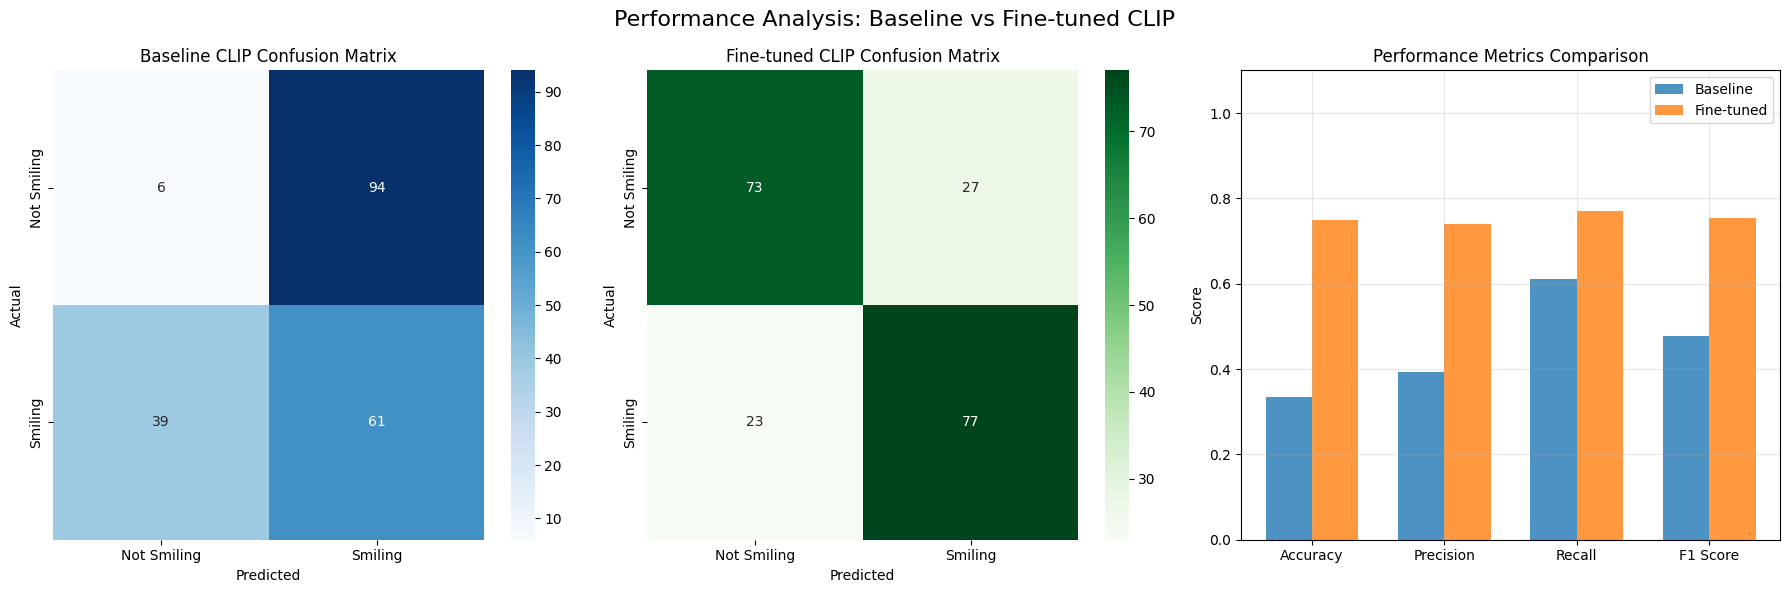


Detailed Performance Results:
Metric         Baseline    Fine-tuned  Change         
------------------------------------------------------------
Accuracy       0.3350      0.7500      +0.4150 (+123.9%)
Precision      0.3935      0.7404      +0.3468 (+88.1%)
Recall         0.6100      0.7700      +0.1600 (+26.2%)
F1 Score       0.4784      0.7549      +0.2765 (+57.8%)

Additional Metrics:
Specificity (TNR):   Baseline 0.0600, Fine-tuned 0.7300
Sensitivity (TPR):   Baseline 0.6100, Fine-tuned 0.7700

Overall Classification:
Total samples: 200
Baseline correct:   67/200 (33.5%)
Fine-tuned correct: 150/200 (75.0%)
Net improvement:    83 more correct


In [23]:
def plot_metrics(metrics, title):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.heatmap(
        metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
        xticklabels=['Not Smiling', 'Smiling'], yticklabels=['Not Smiling', 'Smiling']
    )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    plt.subplot(1, 2, 2)
    names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']]
    plt.bar(names, values)
    plt.ylim(0, 1)
    plt.title('Performance Metrics')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def plot_comprehensive_metrics(baseline, finetuned, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    sns.heatmap(
        baseline['confusion_matrix'], annot=True, fmt='d', ax=ax1, cmap='Blues',
        xticklabels=['Not Smiling', 'Smiling'], yticklabels=['Not Smiling', 'Smiling']
    )
    ax1.set_title('Baseline CLIP Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    sns.heatmap(
        finetuned['confusion_matrix'], annot=True, fmt='d', ax=ax2, cmap='Greens',
        xticklabels=['Not Smiling', 'Smiling'], yticklabels=['Not Smiling', 'Smiling']
    )
    ax2.set_title('Fine-tuned CLIP Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    x = np.arange(len(metrics))
    width = 0.35
    base_vals = [baseline[m] for m in metrics]
    tune_vals = [finetuned[m] for m in metrics]

    ax3.bar(x - width/2, base_vals, width, label='Baseline', alpha=0.8)
    ax3.bar(x + width/2, tune_vals, width, label='Fine-tuned', alpha=0.8)
    ax3.set_ylabel('Score')
    ax3.set_title('Performance Metrics Comparison')
    ax3.set_xticks(x)
    ax3.set_xticklabels([m.title().replace('_', ' ') for m in metrics])
    ax3.legend()
    ax3.set_ylim(0, 1.1)
    ax3.grid(alpha=0.3)

    plt.suptitle(title, fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()


def compute_metrics(labels, preds):
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds, average='binary'),
        'recall': recall_score(labels, preds, average='binary'),
        'f1_score': f1_score(labels, preds, average='binary'),
        'confusion_matrix': confusion_matrix(labels, preds)
    }


def evaluate(
    model, processor, dataloader, device,
    classification_head=None, zero_shot=False,
    text_prompts=None
):
    model.eval()
    if classification_head:
        classification_head.eval()

    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            imgs, lbls = batch['image'], batch['label']
            if classification_head:
                lbls = lbls.to(device)
                ins = processor(images=imgs, return_tensors='pt', padding=True)
                ins = {k: v.to(device) for k, v in ins.items()}
                feats = model.get_image_features(pixel_values=ins['pixel_values'])
                logits = classification_head(feats)
            else:
                prompts = text_prompts or ["a photo of a person not smiling","a photo of a person smiling"]
                ins = processor(text=prompts, images=imgs, return_tensors='pt', padding=True)
                ins = {k: v.to(device) for k, v in ins.items()}
                logits = model(**ins).logits_per_image
                preds = 1 - logits.argmax(dim=-1).cpu().numpy()
                probs = torch.softmax(logits, dim=-1)
                all_preds.extend(preds)
                all_labels.extend(lbls.numpy())
                all_probs.extend(probs.cpu().numpy())
                continue

            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(lbls.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    metrics = compute_metrics(all_labels, all_preds)
    metrics.update(predictions=all_preds, labels=all_labels, probabilities=all_probs)
    return metrics


def print_metrics(metrics):
    print("Metrics:")
    for k in ['accuracy','precision','recall','f1_score']:
        print(f"- {k.title()}: {metrics[k]:.4f}")


def print_comparative_metrics(baseline, finetuned):
    print("\nDetailed Performance Results:")
    print("="*60)
    print(f"{'Metric':<15}{'Baseline':<12}{'Fine-tuned':<12}{'Change':<15}")
    print("-"*60)

    for name,key in [('Accuracy','accuracy'),('Precision','precision'),('Recall','recall'),('F1 Score','f1_score')]:
        b,v = baseline[key], finetuned[key]
        diff = v - b
        pct = (diff/b*100) if b else 0
        print(f"{name:<15}{b:<12.4f}{v:<12.4f}{diff:+.4f} ({pct:+.1f}%)")

    tn_b,fp_b,fn_b,tp_b = baseline['confusion_matrix'].ravel()
    tn_f,fp_f,fn_f,tp_f = finetuned['confusion_matrix'].ravel()

    spec_b = tn_b/(tn_b+fp_b) if (tn_b+fp_b)>0 else 0
    spec_f = tn_f/(tn_f+fp_f) if (tn_f+fp_f)>0 else 0
    sens_b = tp_b/(tp_b+fn_b) if (tp_b+fn_b)>0 else 0
    sens_f = tp_f/(tp_f+fn_f) if (tp_f+fn_f)>0 else 0

    print("\nAdditional Metrics:")
    print(f"Specificity (TNR):   Baseline {spec_b:.4f}, Fine-tuned {spec_f:.4f}")
    print(f"Sensitivity (TPR):   Baseline {sens_b:.4f}, Fine-tuned {sens_f:.4f}")

    total = tn_b+fp_b+fn_b+tp_b
    corr_b = tn_b+tp_b
    corr_f = tn_f+tp_f
    print("\nOverall Classification:")
    print(f"Total samples: {total}")
    print(f"Baseline correct:   {corr_b}/{total} ({corr_b/total*100:.1f}%)")
    print(f"Fine-tuned correct: {corr_f}/{total} ({corr_f/total*100:.1f}%)")
    print(f"Net improvement:    {corr_f-corr_b} more correct")


pretrained_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

print("Evaluating baseline CLIP (zero-shot)...")
baseline_metrics = evaluate(model, processor, test_loader, device, zero_shot=True)
print_metrics(baseline_metrics)

print("\nEvaluating fine-tuned model...")
finetuned_metrics = evaluate(model, processor, test_loader, device, classification_head=classification_head)
print_metrics(finetuned_metrics)

plot_comprehensive_metrics(baseline_metrics, finetuned_metrics, "Performance Analysis: Baseline vs Fine-tuned CLIP")
print_comparative_metrics(baseline_metrics, finetuned_metrics)

## Qualitative Analysis - Example Predictions

Getting example predictions from pre-trained model...
Getting example predictions from fine-tuned model...


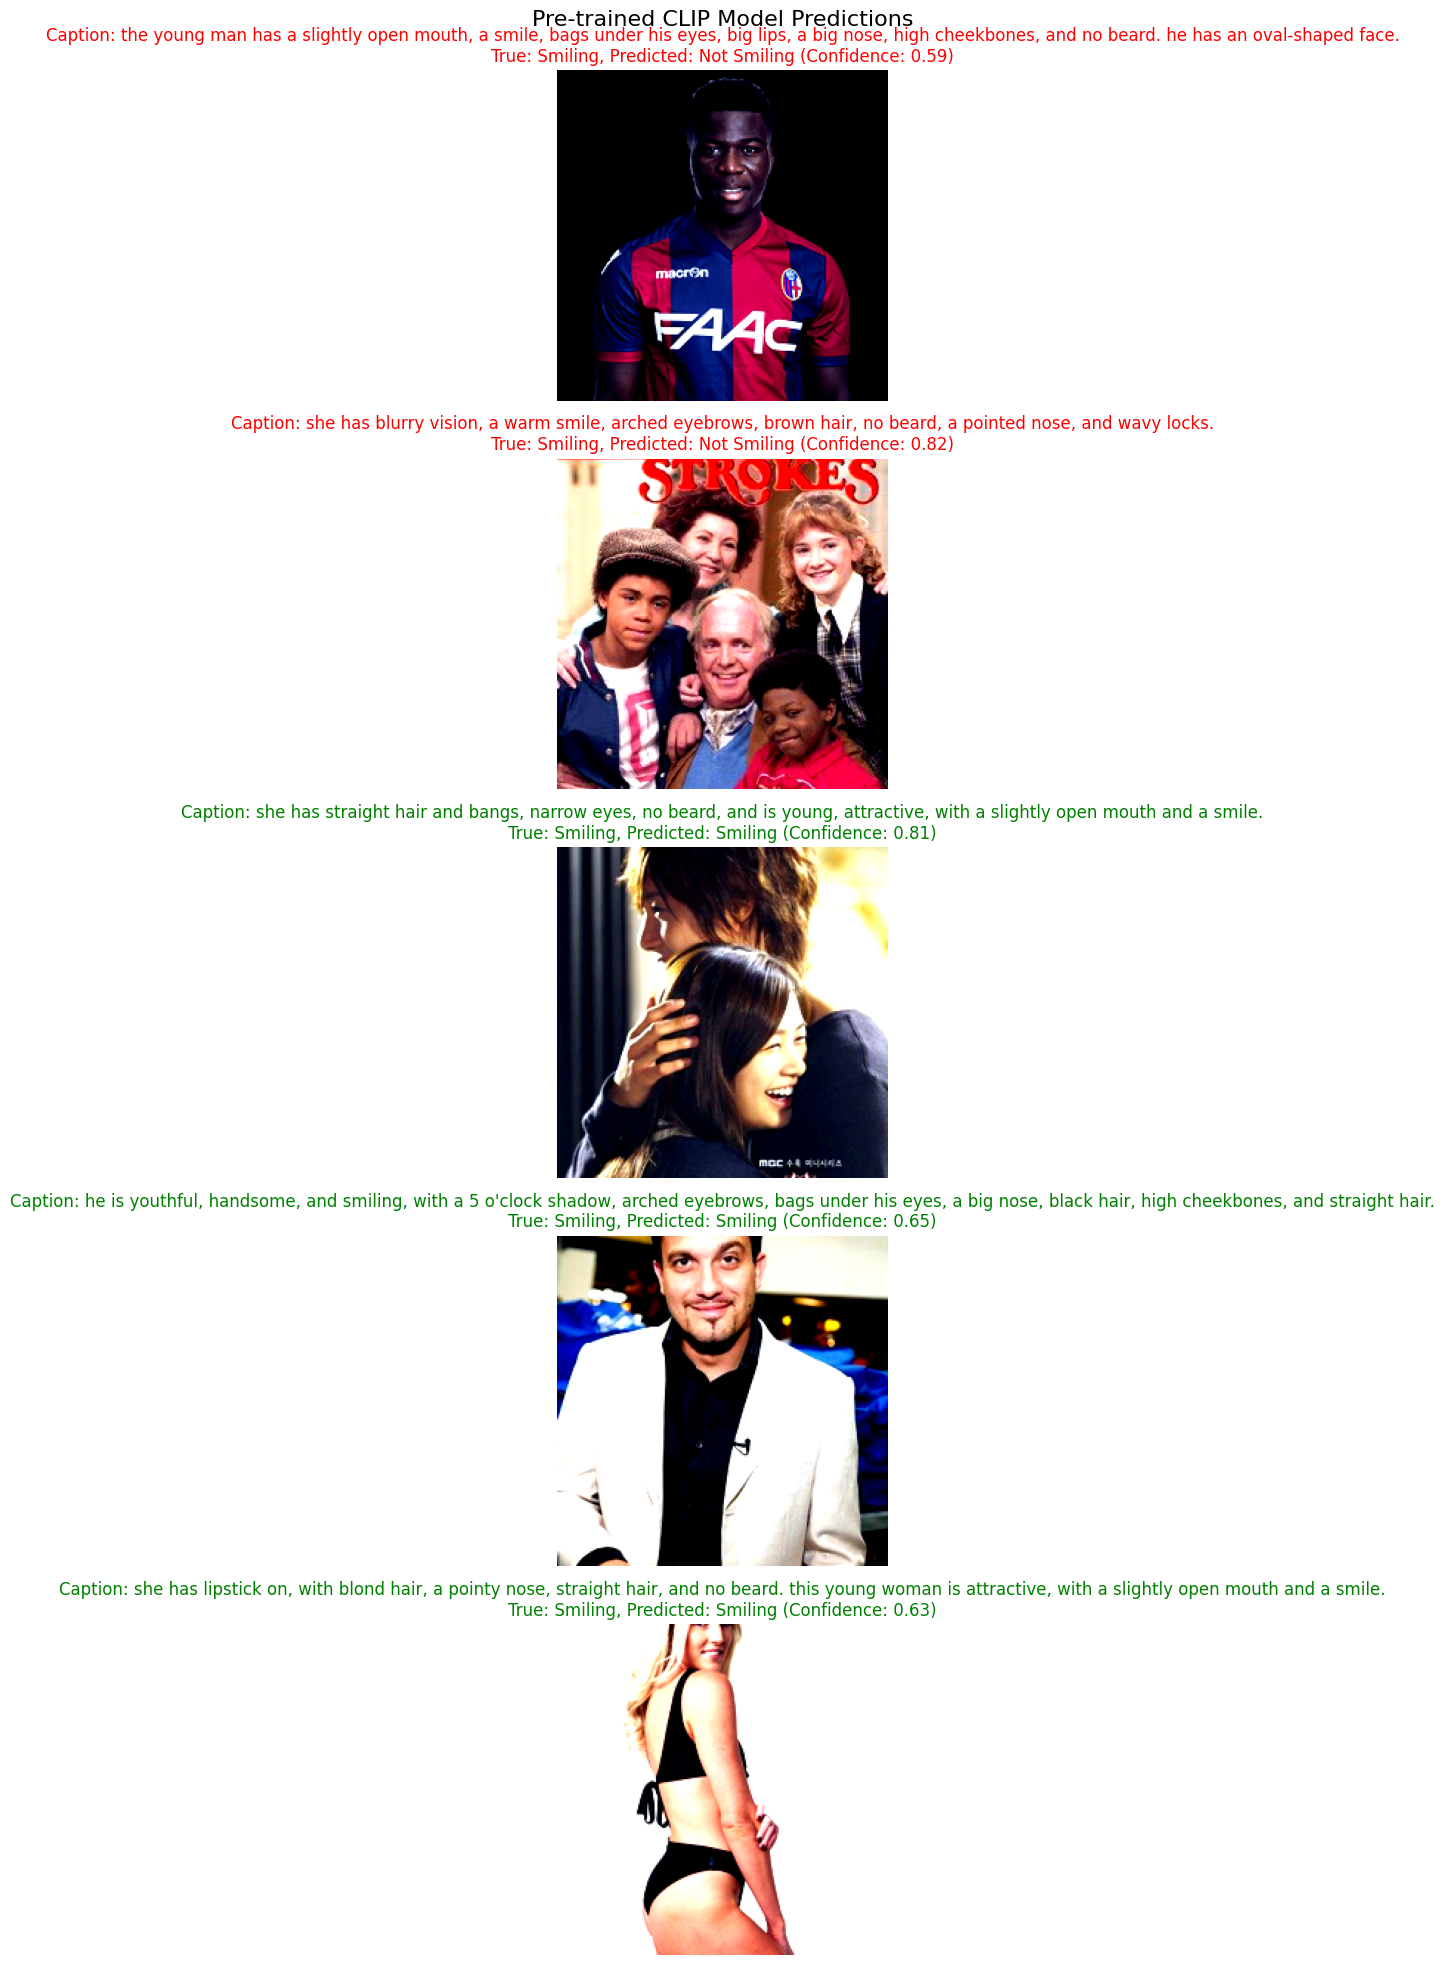

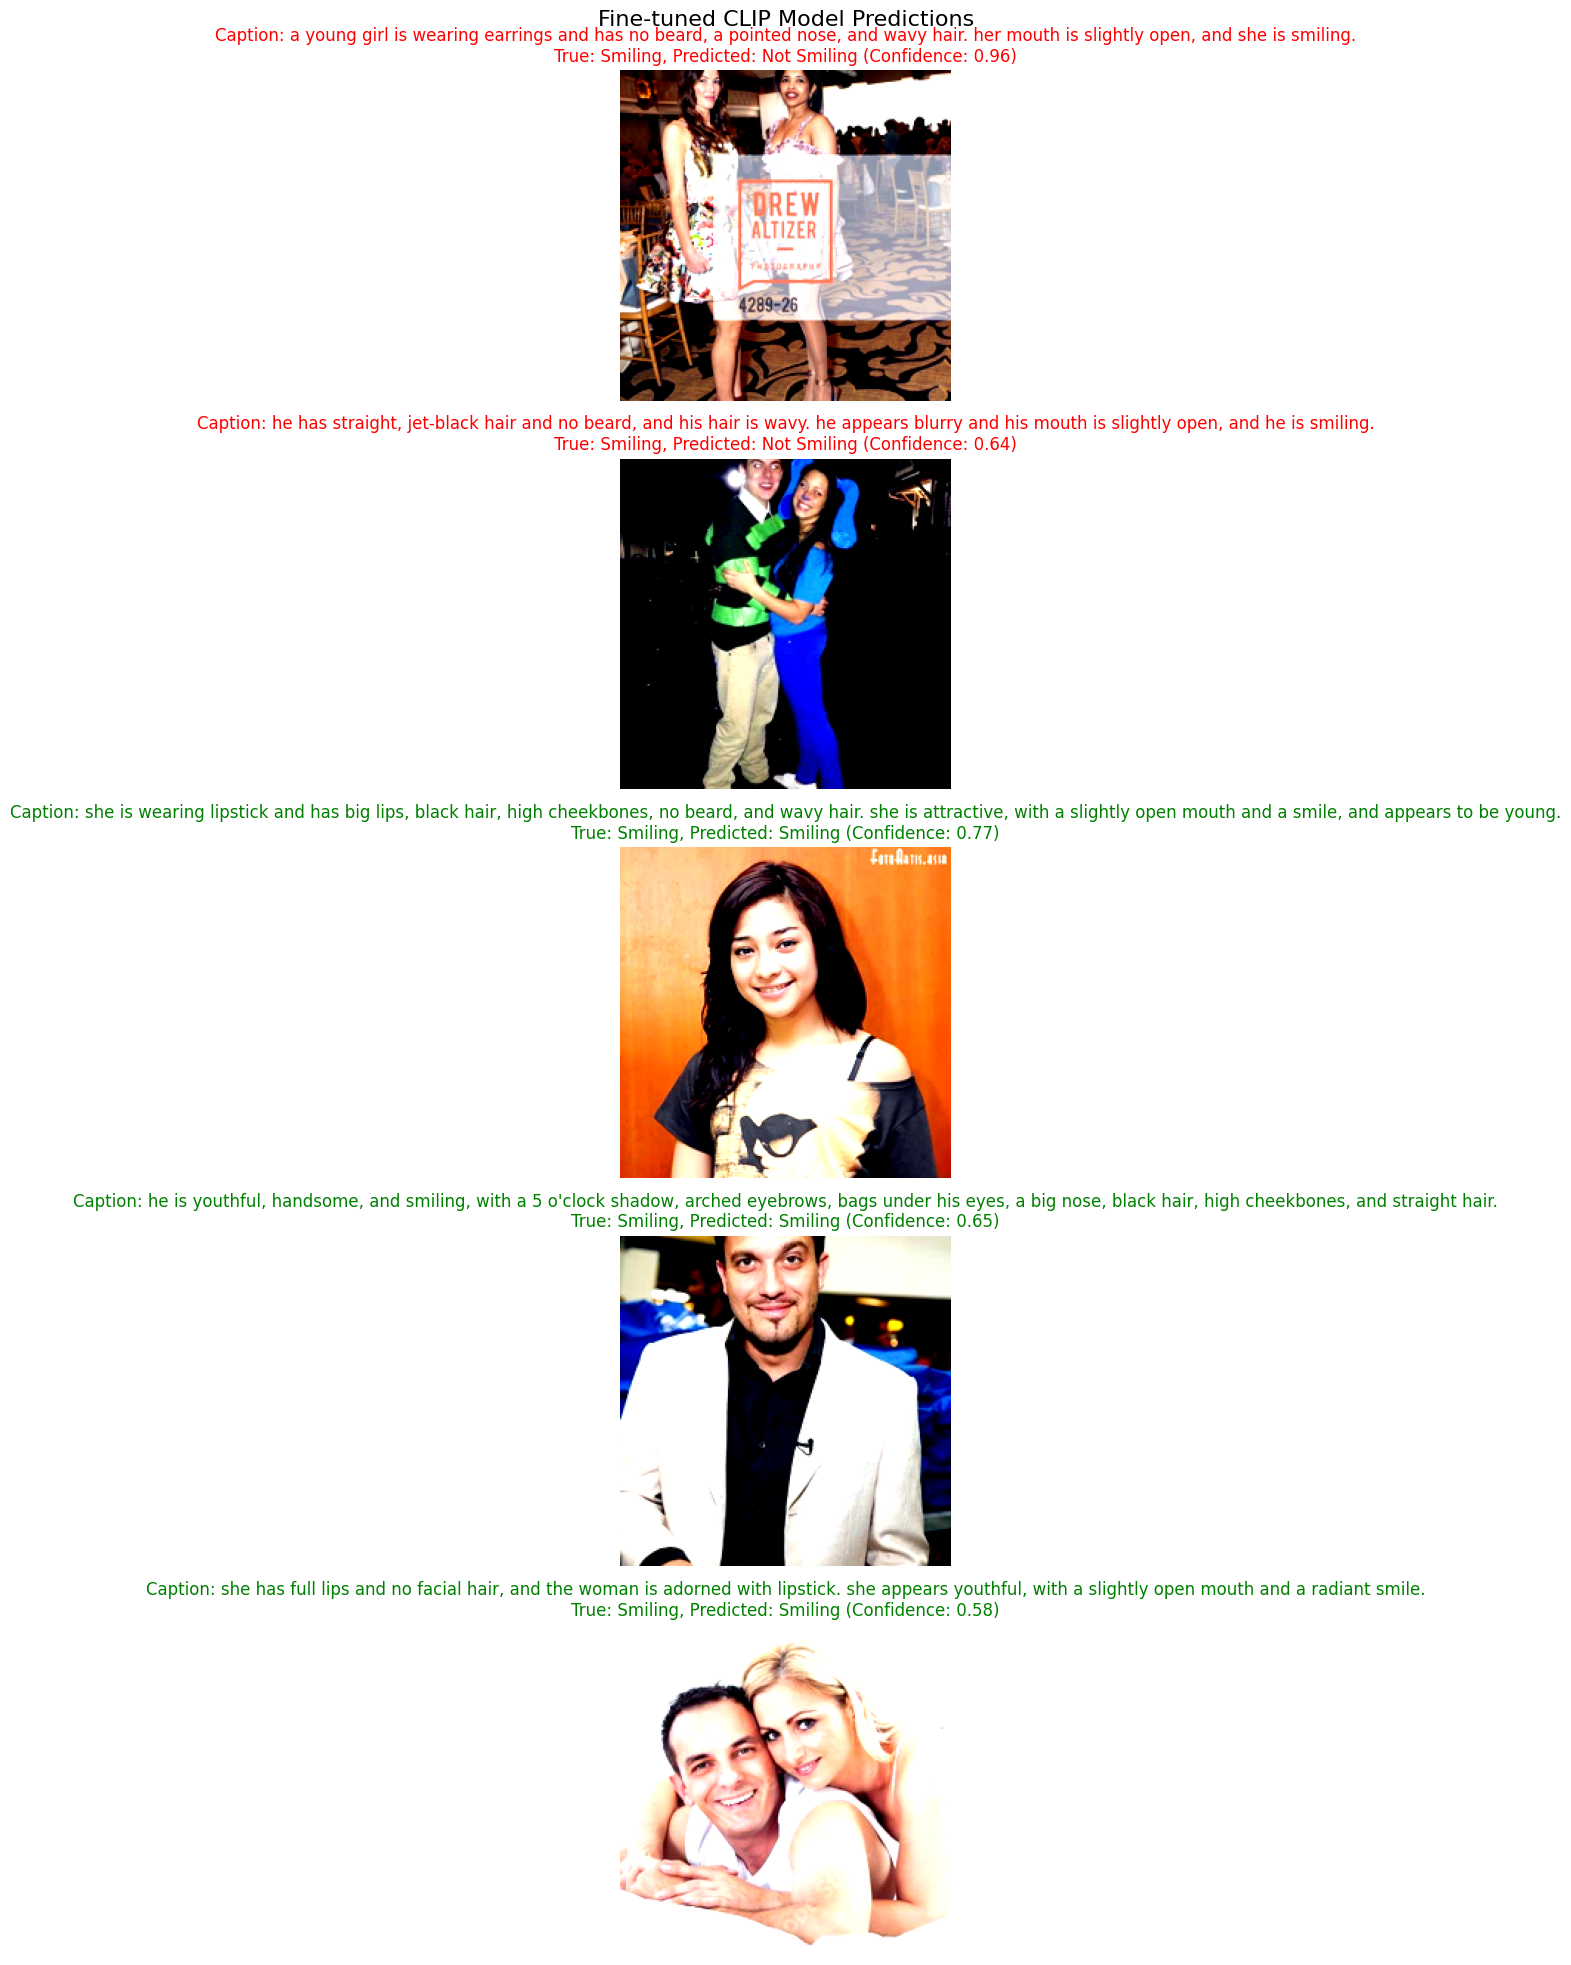

In [24]:
def analyze_examples(model, processor, dataloader, device, num_examples=5):
    model.eval()
    examples = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"]
            image_paths = batch["image_path"]
            captions = batch["caption"]
            labels = batch["label"]

            text_prompts = ["a photo of a person smiling", "a photo of a person not smiling"]

            inputs = processor(
                text=text_prompts,
                images=images,
                return_tensors="pt",
                padding=True
            ).to(device)

            outputs = model(**inputs)
            logits = outputs.logits_per_image

            predictions = logits.argmax(dim=-1).cpu().numpy()
            predictions = 1 - predictions

            probs = torch.nn.functional.softmax(logits, dim=-1).cpu().numpy()

            processed_images = []
            for img in images:
                processed = processor(images=img, return_tensors="pt").pixel_values
                processed_images.append(processed[0].cpu())

            for i in range(len(images)):
                examples.append({
                    "image": processed_images[i],
                    "image_path": image_paths[i],
                    "caption": captions[i],
                    "true_label": labels[i].item(),
                    "prediction": predictions[i],
                    "confidence": probs[i]
                })

            if len(examples) >= num_examples * 3:
                break

    correct_examples = [ex for ex in examples if ex["true_label"] == ex["prediction"]]
    incorrect_examples = [ex for ex in examples if ex["true_label"] != ex["prediction"]]

    selected = []
    if incorrect_examples and len(incorrect_examples) >= num_examples // 2:
        selected.extend(random.sample(incorrect_examples, num_examples // 2))

    remaining = num_examples - len(selected)
    if correct_examples and remaining > 0:
        selected.extend(random.sample(correct_examples, remaining))

    remaining = num_examples - len(selected)
    if remaining > 0 and examples:
        selected.extend(random.sample(examples, remaining))

    return selected[:num_examples]

def visualize_predictions(examples, title):
    num_examples = len(examples)
    fig, axes = plt.subplots(num_examples, 1, figsize=(10, 4 * num_examples))
    if num_examples == 1:
        axes = [axes]

    labels = ["Smiling", "Not Smiling"]

    for i, example in enumerate(examples):
        img = example["image"].permute(1, 2, 0).numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)

        axes[i].imshow(img)

        true_label = labels[1 - example["true_label"]]
        pred_label = labels[1 - example["prediction"]]
        confidence = example["confidence"]

        color = "green" if example["true_label"] == example["prediction"] else "red"

        axes[i].set_title(f"Caption: {example['caption']}\n"
                         f"True: {true_label}, Predicted: {pred_label} "
                         f"(Confidence: {confidence[1 - example['prediction']]:.2f})",
                         color=color)
        axes[i].axis("off")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

print("Getting example predictions from pre-trained model...")
pretrained_examples = analyze_examples(model, processor, test_loader, device)

print("Getting example predictions from fine-tuned model...")
finetuned_examples = analyze_examples(model, processor, test_loader, device)

visualize_predictions(pretrained_examples, "Pre-trained CLIP Model Predictions")
visualize_predictions(finetuned_examples, "Fine-tuned CLIP Model Predictions")